# Lab 8 Morning - Calibrating Photometry
## Names:

***

## Overview

In the previous lab, you extracted aperture photometry for all of the stars in your science images and standard star images.  Today, we want to use that information to do the following: 

* Calculate the instrumental magnitudes of the standard stars and cluster stars, based on your flux measurements.  

* Determine the _zeropoint_: the difference between the instrumental magnitude of a standard star and its known, calibated magnitude value in a given photometric system.  

Afternoon Lab stuff

* Use the zeropoint to calibrate the photometry of cluster stars.  

* Estimate the errors on our measured fluxes, and propagate these errors into our final magnitude calculations.  

* Plot a V vs. V-R color-magnitude diagram for a cluster!

In [4]:
# The standard fare, plus a few extra packages:
import numpy as np
import pandas as pd

%matplotlib notebook
import matplotlib.pyplot as plt

import astropy.io.fits as fits
import os.path


# Newer packages:
from astropy.stats import mad_std
from astropy.stats import sigma_clip
from astropy.visualization import ZScaleInterval
import astropy.stats as stat

from photutils.utils import calc_total_error
from photutils import aperture_photometry, CircularAperture, CircularAnnulus, DAOStarFinder

## 9.1 - Identifying the Standard Star

The first step is to identify the standard star from your reduced images. First, plot a standard star image


In [5]:
# Provide the path to your data directory, the folder with your STACKED reduced science images: 
# The path format should be the absolute path, e.g., "/Users/StudentName/folder/NGC663/Stacked/"
# remember the '/' at the end

datadir = '/Users/sarah/Documents/3GradSchool/TA/UT20191107/Stacked/'


In [6]:
# # name of the stacked V band standard star image in your Stacked folder.
# # (e.g. std_star = 'standard_G3-33_Vstack.fit')

standardname='FS150'
clustername = 'NGC6811'


std_star_B = f'{standardname}_Bstack.fits'
std_star_V = f'{standardname}_Vstack.fits'
std_star_R = f'{standardname}_Rstack.fits'


# name of the stacked V band standard star image in your Stacked folder.
# (e.g. std_star = 'NGC663_Vstack.fit')
cluster_B = f'{clustername}_Bstack.fits'
cluster_V = f'{clustername}_Vstack.fits'
cluster_R = f'{clustername}_Rstack.fits'




In [7]:
# # open standard star image with fits.
std_data_V = fits.getdata(datadir + std_star_V)


<IPython.core.display.Javascript object>


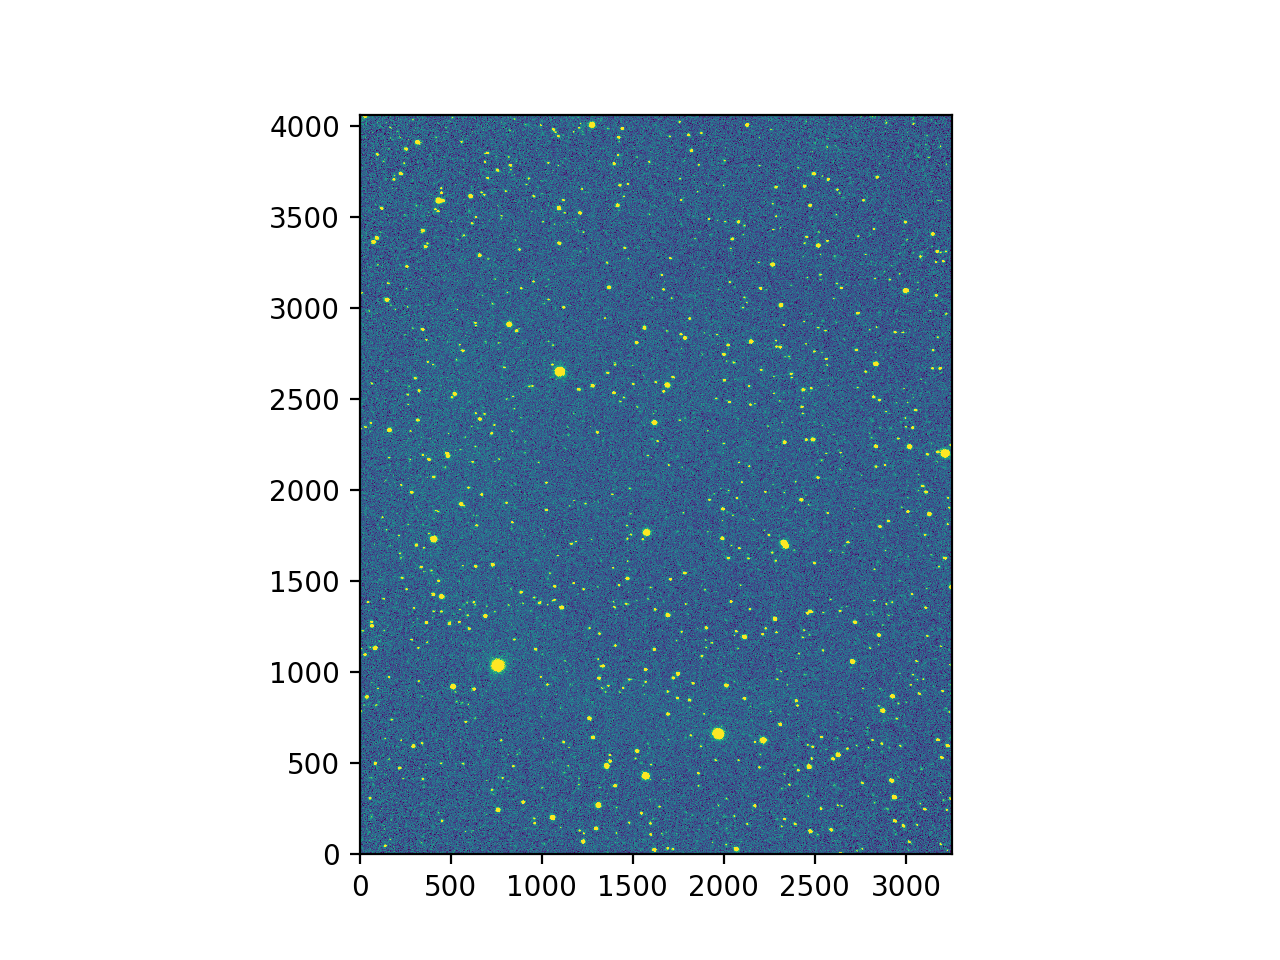

In [8]:
### run this cell to plot your standard star image here.  

plt.figure()
interval = ZScaleInterval()
vmin, vmax = interval.get_limits(std_data_V)
plt.imshow(std_data_V, origin='lower', vmin=vmin, vmax=vmax)
plt.show()




    
Next, use the finder chart from the last lab to find the star in your data. 

Decide which of the stars in your data is the standard star. Check your answer with a parter. Drag your cursor over the image and look in the bottom right corner to determine the (x,y) coordinate of your standard star.  


<div class="alert alert-block alert-warning">
    
**Question:** What are the x-y coordinates of the standard star?  
**Answer:** x = 2409, y=724

Plot a circle around the star in your data. 

<IPython.core.display.Javascript object>


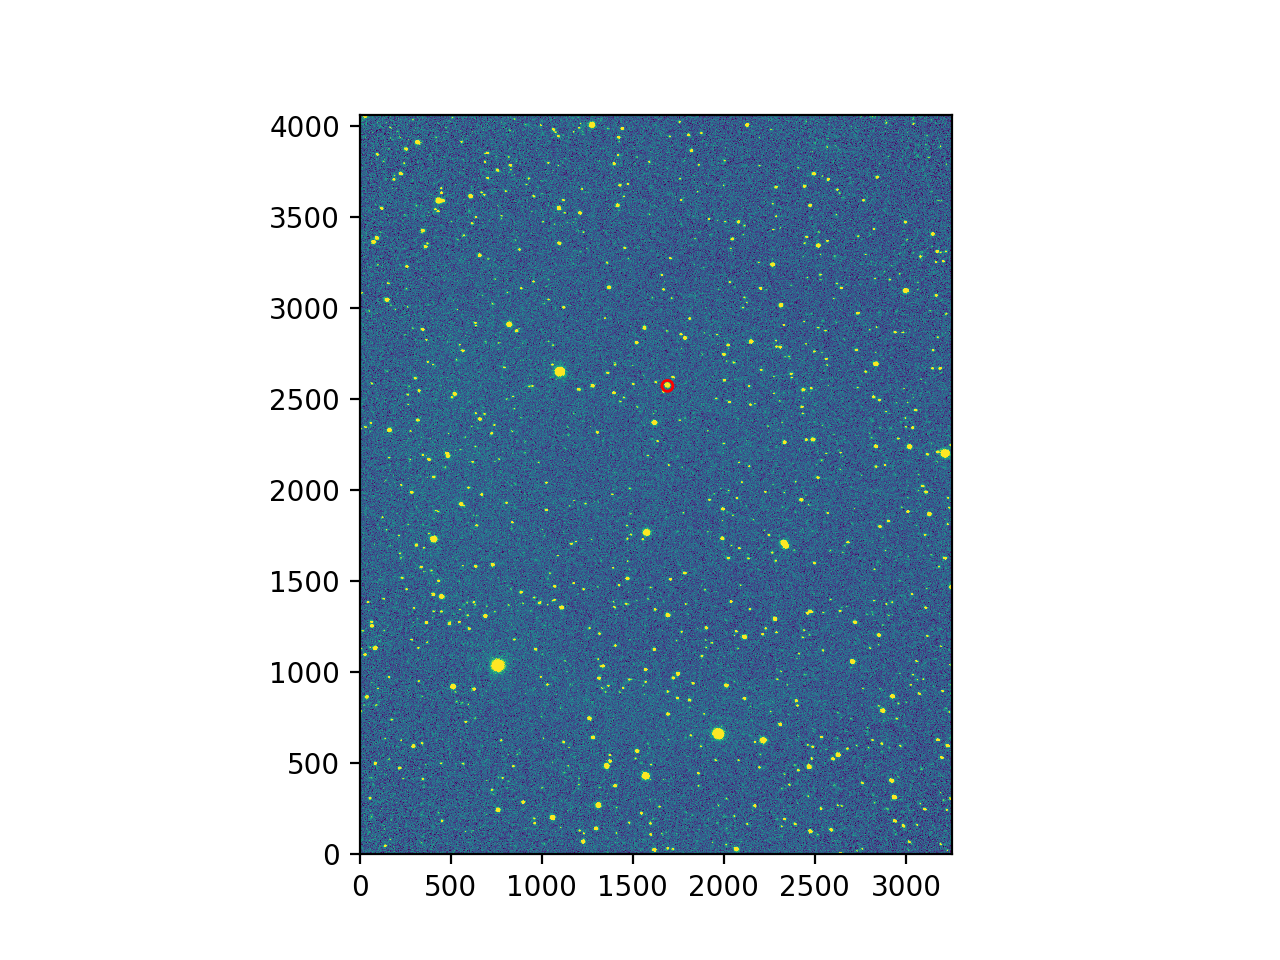

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


In [9]:
# ### Draw a circle around your image.  

# # 1) replot your standard star image
plt.figure()
interval = ZScaleInterval()
vmin, vmax = interval.get_limits(std_data_V)
plt.imshow(std_data_V, origin='lower', vmin=vmin, vmax=vmax)


# 2) plot a circle: change (??,??) to the (x,y) coordinates of your object.  
# Adjust the radius (currently 30) to a good size. 
circle = plt.Circle((1690, 2573), 30, color='red', fill=None)


plt.axes().add_artist(circle)
plt.show()

### 9.2 - Read in cluster & standard star photometry

Now, read in the .csv photometry data for your cluster data and standard star data.  You will isolate the standard star photometry. 

In [10]:
### read in standard star file as pandas dataframe

#inside the () put the path to your .csv file that you created yesterday.
# your path should be like: datadir + 'standard_photometry.csv'
std_fluxtable = pd.read_csv(datadir  + standardname + '_photometry.csv')

std_fluxtable.head()

Unnamed: 0  id      xcenter    ycenter         Bflux    Bfluxerr  \
0           0   1     4.682088   4.543288   3609.301646  124.838353   
1           1   2  3250.326317   4.558860   3348.741270  122.526272   
2           2   3  1616.495658  23.683387  17660.724667  197.451944   
3           3   4  2065.575878  27.409534  28818.000333  219.171107   
4           4   5  1718.459304  27.585627    437.620838  158.633896   

          Vflux    Vfluxerr         Rflux    Rfluxerr  
0   6877.183529  173.047630   7651.159611  183.259977  
1   6665.573255  170.681328   7507.665073  181.948765  
2  40417.271819  282.857257  52755.281458  308.604152  
3  64776.862463  315.886015  81835.677805  344.245651  
4   4332.372648  225.524753  15747.185855  256.709640

In [11]:
std_fluxtable[(std_fluxtable['xcenter'] < 1692) & (std_fluxtable['xcenter']>1687)]

Unnamed: 0   id      xcenter      ycenter         Bflux    Bfluxerr  \
5             5    6  1689.286517    30.717841   1975.896397  163.712005   
136         136  137  1691.250585   767.698535   8679.976290  178.351186   
161         161  162  1689.663468   891.092357   1966.254121  163.719071   
250         250  251  1690.956892  1310.661941  19900.973800  202.346059   
534         534  535  1687.639776  2572.663196  67341.311567  278.867014   

             Vflux    Vfluxerr          Rflux    Rfluxerr  
5      6186.469837  228.658886    9654.193789  247.207668  
136   19248.217347  250.506339   24566.359119  269.255731  
161    5902.966151  228.023141    9731.649121  246.715807  
250   66059.120101  315.290045  117119.566843  378.558348  
534  152611.932355  408.937974  204999.142497  458.148745

<IPython.core.display.Javascript object>


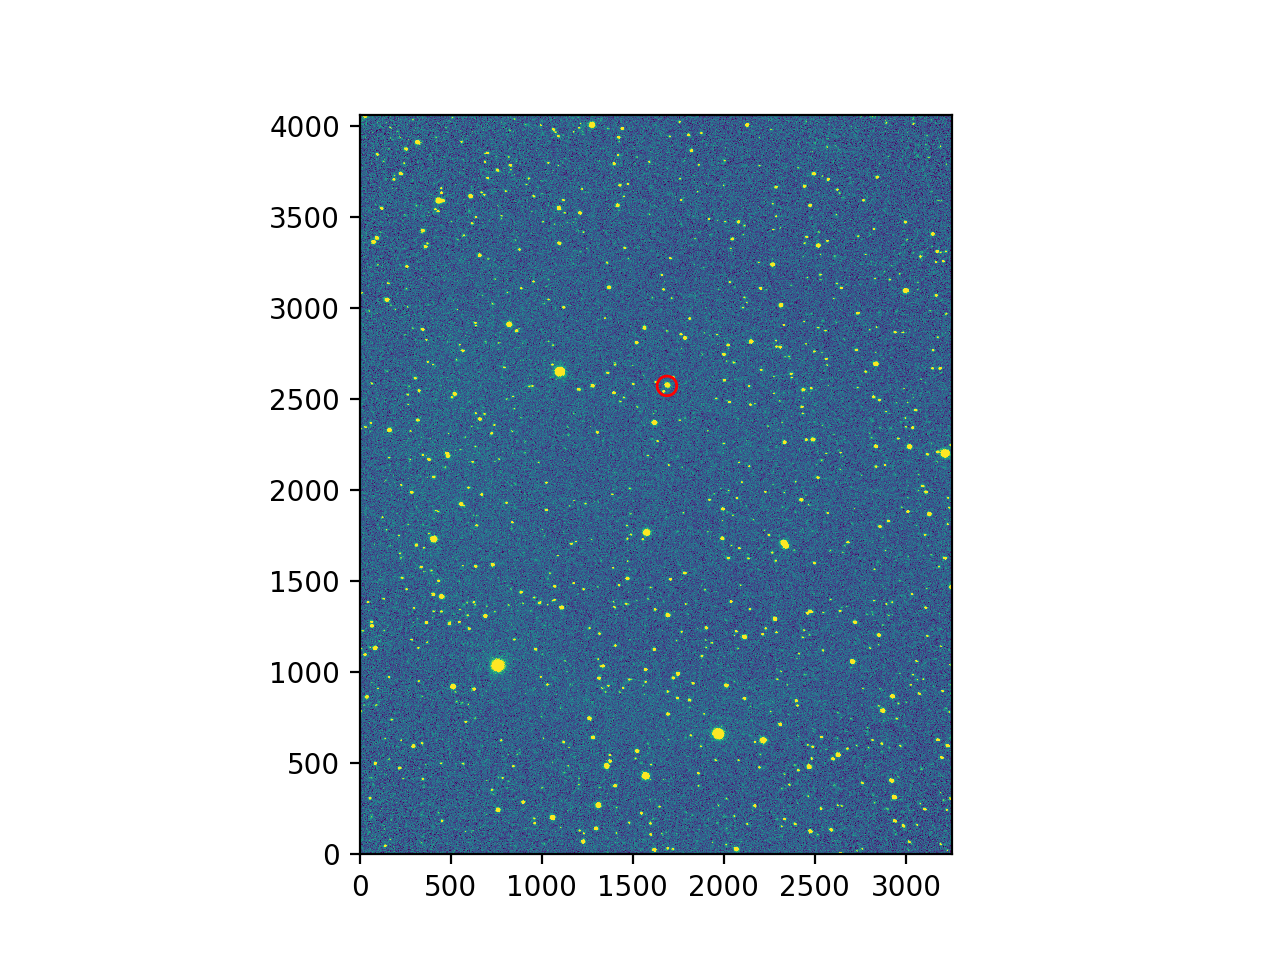

In [12]:
### plot the photometry and see if your standard star was currently identified.

# 1) replot your standard star image (copy and paste your code from above)
plt.figure()
interval = ZScaleInterval()
vmin, vmax = interval.get_limits(std_data_V)
plt.imshow(std_data_V, origin='lower', vmin=vmin, vmax=vmax)


# 2) plot the photometry (x,y) positions as a scatter plot on top of the image
# x = std_fluxtable['xcenter']
# y = std_fluxtable['ycenter']

x = std_fluxtable['xcenter'][534]
y = std_fluxtable['ycenter'][534]

# change the marker, color, and size so the scatter points and stars are both easily visible.  
# Inside the plt.scatter() function:
#     to change the marker: marker = 
#     to make an unfilled marker: facecolor='none'
#     to change the marker of the circle: edgecolor = <color name>
#     to change the size of the marker: s = 
plt.scatter(x,y, marker='o', edgecolor='red', s = 50, facecolor='none')

plt.show()

<div class="alert alert-block alert-warning">
    
**Question:** Was the standard star identified in your photometry?

**Answer:** yes

**Question:** What row is the standard star location in the table above? 

**Answer** 27

In [13]:
# Isolate the single row from the array with the standard star only

# replace ?? with the row number you identified above.
std_star_row = std_fluxtable.loc[534]
# std_star_row
# save to new dataframe
std_star_fluxtable = pd.DataFrame({'standard star':std_star_row}).T
std_star_fluxtable 

Unnamed: 0     id      xcenter      ycenter         Bflux  \
standard star       534.0  535.0  1687.639776  2572.663196  67341.311567   

                 Bfluxerr          Vflux    Vfluxerr          Rflux  \
standard star  278.867014  152611.932355  408.937974  204999.142497   

                 Rfluxerr  
standard star  458.148745

Now, let's read in the cluster photometry data

In [19]:
#inside the () put the path to your .csv file that you created yesterday.
# your path should be like: '/path/to/your/data/Stacked/cluster_photometry.csv'

cluster_fluxtable = pd.read_csv(datadir + '/' + clustername + '_photometry.csv')

## 9.3 - Calculating Instrumental Magnitudes and Measuring Zeropoints 

Note that when calculating zeropoint, units are in *flux per second*, so it's critically important than we divide by exposure time of the image. 

<div class="alert alert-block alert-warning"> 
 
**(1):** What would happen if we simply compared the measured fluxes without performing this scaling for exposure time first?

**Answer:**

The relation for instrumental magnitude is:

$m_{inst} = -2.5 \log_{10}(\frac{\textit{flux}}{ \textit{exposure time}}) = -2.5 \log_{10}(\textit{flux in 1 sec}) $

**Part (a):** Update the pandas dataframes (the .csv file) for both the standard star and cluster by adding new columns `Vflux_1sec` and `Rflux_1sec`, and `Vflux_1sec_err` and `Rflux_1sec_err` by finding $\frac{\rm flux}{\rm exposure \ time}$

standards:
- For G3-33: V band exposure time = 120;  R band exposure time = 120
           
- For SA 93-424 V band exposure time = 60;  R band exposure time = 60
              
cluster: 
- For NGC 663 V band exposure time = 60;  R band exposure time = 60 
            
- For NGC 869 V band exposure time = 60;  R band exposure time = 60
            
- For M52 V band exposure time = 60; R band exposure time = 60
        
- For NGC 189 V band exposure time = 300;  R band exposure time = 180
            
You can check these by opening a raw image in ds9, clicking header, and search for EXPTIME.  

In [14]:
### open a .fits headers for each filter for the standard and cluster data and find the exposure time

std_exp_V = 60
std_exp_B = 60

# # fill in the ?? to get your R band standard star stacked image
std_exp_R = 60

cluster_exp_V = 60

# fill in the ?? to get your R band cluster stacked image
cluster_exp_R = 60
cluster_exp_B = 60

In [15]:
### For the standard star: calculate the normalized flux and flux error by dividing the flux and flux error 
#   in each filter by the exposure time

std_star_fluxtable['Bflux_1sec'] = std_star_fluxtable['Bflux'] / std_exp_B
std_star_fluxtable['Vflux_1sec'] = std_star_fluxtable['Vflux'] / std_exp_V
std_star_fluxtable['Rflux_1sec'] = std_star_fluxtable['Rflux'] / std_exp_R

std_star_fluxtable['Bflux_1sec_err'] = std_star_fluxtable['Bflux_1sec']*(std_star_fluxtable['Bfluxerr']/std_star_fluxtable['Bflux'])
std_star_fluxtable['Vflux_1sec_err'] = std_star_fluxtable['Vflux_1sec']*(std_star_fluxtable['Vfluxerr']/std_star_fluxtable['Vflux'])
std_star_fluxtable['Rflux_1sec_err'] = std_star_fluxtable['Rflux_1sec']*(std_star_fluxtable['Rfluxerr']/std_star_fluxtable['Rflux'])




In [16]:
### Check that new columns were added 
std_star_fluxtable

Unnamed: 0     id      xcenter      ycenter         Bflux  \
standard star       534.0  535.0  1687.639776  2572.663196  67341.311567   

                 Bfluxerr          Vflux    Vfluxerr          Rflux  \
standard star  278.867014  152611.932355  408.937974  204999.142497   

                 Rfluxerr   Bflux_1sec   Vflux_1sec   Rflux_1sec  \
standard star  458.148745  1122.355193  2543.532206  3416.652375   

               Bflux_1sec_err  Vflux_1sec_err  Rflux_1sec_err  
standard star        4.647784        6.815633        7.635812

In [17]:
### For the cluster stars: calculate the normalized flux and flux error by dividing the flux and flux error 
#   in each filter by the exposure time

cluster_fluxtable['Vflux_1sec'] = cluster_fluxtable['Vflux'] / cluster_exp_V
cluster_fluxtable['Rflux_1sec'] = cluster_fluxtable['Rflux'] / cluster_exp_R
cluster_fluxtable['Bflux_1sec'] = cluster_fluxtable['Bflux'] / cluster_exp_B



cluster_fluxtable['Vflux_1sec_err'] = cluster_fluxtable['Vflux_1sec']*(cluster_fluxtable['Vfluxerr']/cluster_fluxtable['Vflux'])
cluster_fluxtable['Rflux_1sec_err']= cluster_fluxtable['Rflux_1sec']*(cluster_fluxtable['Rfluxerr']/cluster_fluxtable['Rflux'])
cluster_fluxtable['Bflux_1sec_err']= cluster_fluxtable['Bflux_1sec']*(cluster_fluxtable['Bfluxerr']/cluster_fluxtable['Bflux'])





NameError: name 'cluster_fluxtable' is not defined

In [18]:
### Check that new columns were added 
cluster_fluxtable.head()

NameError: name 'cluster_fluxtable' is not defined

**Part (b):** Calculate the instrumental magnitudes (label them "V_inst" and "R_inst"), and also add these as new columns to your ever-growing standard star and cluster dataframes.

In [17]:
# # Your code here

std_star_fluxtable['B_inst'] = -2.5*np.log10(std_star_fluxtable['Bflux_1sec'])
std_star_fluxtable['V_inst'] = -2.5*np.log10(std_star_fluxtable['Vflux_1sec'])
std_star_fluxtable['R_inst'] = -2.5*np.log10(std_star_fluxtable['Rflux_1sec'])

std_star_fluxtable.head()



Unnamed: 0     id      xcenter      ycenter         Bflux  \
standard star       534.0  535.0  1687.639776  2572.663196  67341.311567   

                 Bfluxerr          Vflux    Vfluxerr          Rflux  \
standard star  278.867014  152611.932355  408.937974  204999.142497   

                 Rfluxerr   Bflux_1sec   Vflux_1sec   Rflux_1sec  \
standard star  458.148745  1122.355193  2543.532206  3416.652375   

               Bflux_1sec_err  Vflux_1sec_err  Rflux_1sec_err    B_inst  \
standard star        4.647784        6.815633        7.635812 -7.625326   

                 V_inst    R_inst  
standard star -8.513593 -8.834002

In [18]:
cluster_fluxtable['V_inst'] = -2.5*np.log10(cluster_fluxtable['Vflux_1sec'])
cluster_fluxtable['R_inst'] = -2.5*np.log10(cluster_fluxtable['Rflux_1sec'])
cluster_fluxtable['B_inst'] = -2.5*np.log10(cluster_fluxtable['Bflux_1sec'])


cluster_fluxtable.head()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


Unnamed: 0  id      xcenter    ycenter         Bflux    Bfluxerr  \
0           0   1  4076.750152   2.341618   1472.533352   94.094888   
1           1   2    71.189050  28.852097  12253.092893  172.707731   
2           2   3  3859.322153  57.863106   2653.084261  146.777057   
3           3   4  2124.407218  68.677304  31293.900027  211.747941   
4           4   5  1160.779125  74.199104   7631.995394  159.036807   

          Vflux    Vfluxerr         Rflux    Rfluxerr  Vflux_1sec  Rflux_1sec  \
0   2553.405411  126.458698   2566.958400  126.448947   42.556757   42.782640   
1  23852.827164  233.908173  28856.467984  244.581798  397.547119  480.941133   
2   5753.475593  197.020586   6300.603659  199.416217   95.891260  105.010061   
3  56940.764425  283.118968  44525.585725  272.165055  949.012740  742.093095   
4  15583.404351  216.090230  16121.968600  218.885383  259.723406  268.699477   

   Bflux_1sec  Vflux_1sec_err  Rflux_1sec_err  Bflux_1sec_err    V_inst  \
0   24.542223        2.107645        2.107482        1.568248 -4.072421   
1  204.218215        3.898470        4.076363        2.878462 -6.498472   
2   44.218071        3.283676        3.323604        2.446284 -4.954448   
3  521.565000        4.718649        4.536084        3.529132 -7.443180   
4  127.199923        3.601504        3.648090        2.650613 -6.036278   

     R_inst    B_inst  
0 -4.078169 -3.474785  
1 -6.705230 -5.775236  
2 -5.053077 -4.113999  
3 -7.176146 -6.793271  
4 -6.073167 -5.261217

**Part (c):** Propagate errors on the fluxes into errors on the instrumental magnitudes:

The uncertainty propagation for log values goes as follows:

If $x = k * log(a)$, where is $k$ is a constant value, then we can evaluate the uncertainty on $x$, that is $\sigma_{x}$ as:

$\sigma_{x} = k * 0.434 \frac{\sigma_{a}}{a}$


Add these to your two pandas dataframes as new columns,

"Vinst_err", "Rinst_err"


In [19]:
# # Your code here
std_star_fluxtable['Binst_err'] = -2.5*0.434*(std_star_fluxtable['Bflux_1sec_err']/std_star_fluxtable['Bflux_1sec'])
std_star_fluxtable['Vinst_err'] = -2.5*0.434*(std_star_fluxtable['Vflux_1sec_err']/std_star_fluxtable['Vflux_1sec'])
std_star_fluxtable['Rinst_err'] = -2.5*0.434*(std_star_fluxtable['Rflux_1sec_err']/std_star_fluxtable['Rflux_1sec'])

cluster_fluxtable['Vinst_err'] = -2.5*0.434*(cluster_fluxtable['Vflux_1sec_err']/cluster_fluxtable['Vflux_1sec'])
cluster_fluxtable['Rinst_err'] = -2.5*0.434*(cluster_fluxtable['Rflux_1sec_err']/cluster_fluxtable['Rflux_1sec'])
cluster_fluxtable['Binst_err'] = -2.5*0.434*(cluster_fluxtable['Bflux_1sec_err']/cluster_fluxtable['Bflux_1sec'])



In [20]:
# # Check the tables again in the following cells
std_star_fluxtable.head()

Unnamed: 0     id      xcenter      ycenter         Bflux  \
standard star       534.0  535.0  1687.639776  2572.663196  67341.311567   

                 Bfluxerr          Vflux    Vfluxerr          Rflux  \
standard star  278.867014  152611.932355  408.937974  204999.142497   

                 Rfluxerr  ...   Rflux_1sec  Bflux_1sec_err  Vflux_1sec_err  \
standard star  458.148745  ...  3416.652375        4.647784        6.815633   

               Rflux_1sec_err    B_inst    V_inst    R_inst  Binst_err  \
standard star        7.635812 -7.625326 -8.513593 -8.834002  -0.004493   

               Vinst_err  Rinst_err  
standard star  -0.002907  -0.002425  

[1 rows x 22 columns]

In [21]:
cluster_fluxtable.head()

Unnamed: 0  id      xcenter    ycenter         Bflux    Bfluxerr  \
0           0   1  4076.750152   2.341618   1472.533352   94.094888   
1           1   2    71.189050  28.852097  12253.092893  172.707731   
2           2   3  3859.322153  57.863106   2653.084261  146.777057   
3           3   4  2124.407218  68.677304  31293.900027  211.747941   
4           4   5  1160.779125  74.199104   7631.995394  159.036807   

          Vflux    Vfluxerr         Rflux    Rfluxerr  ...  Bflux_1sec  \
0   2553.405411  126.458698   2566.958400  126.448947  ...   24.542223   
1  23852.827164  233.908173  28856.467984  244.581798  ...  204.218215   
2   5753.475593  197.020586   6300.603659  199.416217  ...   44.218071   
3  56940.764425  283.118968  44525.585725  272.165055  ...  521.565000   
4  15583.404351  216.090230  16121.968600  218.885383  ...  127.199923   

   Vflux_1sec_err  Rflux_1sec_err  Bflux_1sec_err    V_inst    R_inst  \
0        2.107645        2.107482        1.568248 -4.072421 -4.078169   
1        3.898470        4.076363        2.878462 -6.498472 -6.705230   
2        3.283676        3.323604        2.446284 -4.954448 -5.053077   
3        4.718649        4.536084        3.529132 -7.443180 -7.176146   
4        3.601504        3.648090        2.650613 -6.036278 -6.073167   

     B_inst  Vinst_err  Rinst_err  Binst_err  
0 -3.474785  -0.053735  -0.053447  -0.069332  
1 -5.775236  -0.010640  -0.009196  -0.015293  
2 -4.113999  -0.037154  -0.034341  -0.060026  
3 -6.793271  -0.005395  -0.006632  -0.007342  
4 -5.261217  -0.015045  -0.014731  -0.022609  

[5 rows x 22 columns]


 Look up the actual magnitude values for the standard star using the Simbad Astronomical Database: 
 
 In the Query an Idenfier -> Idenfier search bar, type in your standard star name (either G3-33 OR SA 93-424)

http://simbad.u-strasbg.fr/simbad/sim-fid

Go to where it say **Fluxes** and find the V and R fluxes and errors.  (Errors are in square brackets)


<img src="vizier.png">



 

<div class="alert alert-block alert-warning">
    
**(1)** What are the actual V and R band magnitudes for your standard star, and what are their uncertainties? (bracketed values)  
**Answer:** V = 12.298 [0.003]
            
R = 10.943 [0.0008]
    
    
    
    

Now we can use these values for the standard star to determine the zeropoints, as follows:

$m_{calibrated} = m_{inst} + zeropoint$

So to determine the zeropoints, we will need to propagate uncertainties. (Writing zeropoint as magzp):

$magzp \pm \sigma_{magzp}$ = ($m_{calib} \pm \sigma_{m_{calib}}$) - ($m_{inst} \pm \sigma_{m_{inst}}$ )


<div class="alert alert-block alert-warning">
    
**(2)** How do you calculate the value of $\sigma_{magzp}$?  
**Answer:**

**(3)** What are your V and R band instrumental magnitudes and uncertainties of the standard star (from your table)?  
**Answer:** V -7.658669	[-0.003087]

 R -8.894707	[-0.000989]

<div class="alert alert-block alert-danger">
    
Finally, in the cell below calculate the zeropoints for each band. Before proceeding, check your method of calculating the uncertainty on each zeropoint from the errors on the insturmental and calibrated magnitudes. After you've estimated the zeropoints, pause here and check with your group members and instructors.




Example:

    -Real V magnitude = 12.070

    -Real V magnitude error = 0.004

    -Your measured V magnitude = -7.562573

    -Your measured V magnitude error = -0.008486


$magzp_V = 12.070 - (-7.562573)$

$magzp_{Verror} = \sqrt{(-0.008486)^2 + 0.004^2}$

In [22]:
std_star_fluxtable

Unnamed: 0     id      xcenter      ycenter         Bflux  \
standard star       534.0  535.0  1687.639776  2572.663196  67341.311567   

                 Bfluxerr          Vflux    Vfluxerr          Rflux  \
standard star  278.867014  152611.932355  408.937974  204999.142497   

                 Rfluxerr  ...   Rflux_1sec  Bflux_1sec_err  Vflux_1sec_err  \
standard star  458.148745  ...  3416.652375        4.647784        6.815633   

               Rflux_1sec_err    B_inst    V_inst    R_inst  Binst_err  \
standard star        7.635812 -7.625326 -8.513593 -8.834002  -0.004493   

               Vinst_err  Rinst_err  
standard star  -0.002907  -0.002425  

[1 rows x 22 columns]

In [23]:
## remember: exponents are ** (2**2 = 4)

magzp_B = 11.53 - (-7.625326)

magzp_B_error = np.sqrt(.07**2. + (-0.004493)**2.)


magzp_V = 11.07 - (-8.513593)

magzp_V_error = np.sqrt(.07**2. + (-0.002907)**2.)

magzp_R = 10.8 - (-8.834002)

magzp_R_error = np.sqrt(0.000**2. + (-0.002425)**2.)

In [24]:
print("Zeropoint in B: ", magzp_B, "+/-", magzp_B_error)
print("Zeropoint in V: ", magzp_V, "+/-", magzp_V_error)
print("Zeropoint in R: ", magzp_R, "+/-", magzp_R_error)

Zeropoint in B:  19.155326 +/- 0.0701440450002707
Zeropoint in V:  19.583593 +/- 0.07006033577567268
Zeropoint in R:  19.634002000000002 +/- 0.002425


## 9.4 - Calibrate Cluster Photometry using the Zeropoint Offsets 

Now that we have the zeropoint values in hand, we can efficiently calibrate all of the fluxes in the cluster dataframe.  

Apply your zeropoints to your cluster V and R band instumental magnitudes to find the calibrated magnitudes:

$m_{cal} = m_{inst} + magzp$


In [25]:
# calibrate your V band cluster

cluster_fluxtable['V_mcal'] = cluster_fluxtable['V_inst'] + magzp_V

# fill in the ?? to calibrate the R_inst column using the magzp_R zeropoint
cluster_fluxtable['R_mcal'] = cluster_fluxtable['R_inst'] + magzp_R

# fill in the ?? to calibrate the R_inst column using the magzp_R zeropoint
cluster_fluxtable['B_mcal'] = cluster_fluxtable['B_inst'] + magzp_B


#fill in the ?? to calibrate the Rinst_err column using the magzp_R_error zeropoint
cluster_fluxtable['B_mcal_err'] = np.sqrt((cluster_fluxtable['Binst_err'])**2 + magzp_B_error**2)

# find the uncertainty in our calibrated magnitude
cluster_fluxtable['V_mcal_err'] = np.sqrt((cluster_fluxtable['Vinst_err'])**2 + magzp_V_error**2)

#fill in the ?? to calibrate the Rinst_err column using the magzp_R_error zeropoint
cluster_fluxtable['R_mcal_err'] = np.sqrt((cluster_fluxtable['Rinst_err'])**2 + magzp_R_error**2)



In [26]:
# Look at dataframe snippet
cluster_fluxtable

Unnamed: 0   id      xcenter      ycenter         Bflux     Bfluxerr  \
0             0    1  4076.750152     2.341618  1.472533e+03    94.094888   
1             1    2    71.189050    28.852097  1.225309e+04   172.707731   
2             2    3  3859.322153    57.863106  2.653084e+03   146.777057   
3             3    4  2124.407218    68.677304  3.129390e+04   211.747941   
4             4    5  1160.779125    74.199104  7.631995e+03   159.036807   
5             5    6  3059.488221    74.619848  2.163888e+04   192.375415   
6             6    7  2122.013849    73.952751  3.480347e+04   215.707283   
7             7    8  3056.870953    79.102431  2.365618e+04   194.646542   
8             8    9  3407.489754    84.270591  1.120322e+06   975.712347   
9             9   10  1492.874269    83.574882  1.502931e+04   177.219971   
10           10   11  3405.468908    86.665860  1.319124e+06  1018.437467   
11           11   12  1490.823365    86.976696  1.731017e+04   179.858533   
12           12   13   488.881019    90.496119  3.558591e+03   148.918011   
13           13   14  3255.722384    90.335506  2.502290e+04   202.419560   
14           14   15  1490.761786    88.642875  1.618350e+04   178.450942   
15           15   16  2905.733568    92.223359  3.522899e+03   148.483949   
16           16   17  3404.289083    88.315739  1.258321e+06  1007.426933   
17           17   18  3254.284245    93.701389  3.165968e+04   209.161730   
18           18   19   422.535988    94.913377  2.844833e+04   204.350530   
19           19   20   489.159230    93.986090  2.803243e+03   147.830608   
20           20   21  2904.716429    94.553182  3.422740e+03   148.546512   
21           21   22   420.566613    98.034062  3.072470e+04   207.113614   
22           22   23  3253.247266    95.644129  3.026959e+04   207.587970   
23           23   24   420.769374    99.473272  2.897441e+04   205.132557   
24           24   25  1045.948555   106.405574  2.042307e+04   187.867502   
25           25   26  1043.957749   109.699276  2.242819e+04   190.413903   
26           26   27  1044.005198   111.673336  2.032711e+04   187.717553   
27           27   28  3642.346898   116.486128  4.810296e+03   153.082594   
28           28   29  2350.384837   119.467674  9.100737e+03   163.360032   
29           29   30  3640.728675   119.162296  5.613552e+03   153.919024   
..          ...  ...          ...          ...           ...          ...   
810         810  811  1318.423705  3817.134855  2.806022e+03   149.030453   
811         811  812   159.022005  3816.976241  9.746405e+03   163.493550   
812         812  813  2570.404063  3816.579878  4.287657e+03   152.101344   
813         813  814  2709.191057  3816.042808  5.194813e+03   153.730453   
814         814  815   893.962597  3817.760229  3.234691e+03   149.785285   
815         815  816   644.511593  3819.399935  7.582446e+03   160.185015   
816         816  817  1315.744381  3822.049478  2.691045e+03   150.715240   
817         817  818  1975.921436  3831.177421  4.276715e+03   152.150286   
818         818  819  2550.734850  3851.445359  5.606980e+03   160.797777   
819         819  820  2548.251386  3853.101299  5.868520e+03   161.512727   
820         820  821  1841.595958  3856.666590  1.959642e+04   189.271726   
821         821  822  2555.423222  3865.075884  4.096487e+03   159.853899   
822         822  823  1839.157765  3861.940970  2.115175e+04   190.733668   
823         823  824  2552.873804  3866.733450  5.092317e+03   160.301118   
824         824  825  3197.297577  3866.213343  2.536880e+03   147.954690   
825         825  826  2552.587275  3868.461837  5.063628e+03   158.793408   
826         826  827  2392.954349  3875.268570  6.462330e+03   159.415433   
827         827  828  4052.115817  3874.288015 -2.588841e+01   140.660647   
828         828  829  3583.571129  3876.239493  3.705246e+03   153.680725   
829         829  830  2390.907198  3878.287190  7.416619e+03   159.544689   
8

<div class="alert alert-block alert-warning"> 

**Question:** What range of magnitude values for the V and R band are the stars in our cluster?  Are they super bright, dim?

**Answer:**

The final step for our photometry table is to calculate a color, namely V-R. Add this quantity as a final column with its error calculated from the relative errors on V and R. Then we will write the table to a file and save it!

In [27]:
# Add V-R error columns and other color columns
cluster_fluxtable['B-V'] = cluster_fluxtable['B_mcal'] - cluster_fluxtable['V_mcal']
cluster_fluxtable['B-V_err'] = np.sqrt((cluster_fluxtable['B_mcal_err'])**2 + (cluster_fluxtable['V_mcal_err'])**2)


In [28]:
cluster_fluxtable

Unnamed: 0   id      xcenter      ycenter         Bflux     Bfluxerr  \
0             0    1  4076.750152     2.341618  1.472533e+03    94.094888   
1             1    2    71.189050    28.852097  1.225309e+04   172.707731   
2             2    3  3859.322153    57.863106  2.653084e+03   146.777057   
3             3    4  2124.407218    68.677304  3.129390e+04   211.747941   
4             4    5  1160.779125    74.199104  7.631995e+03   159.036807   
5             5    6  3059.488221    74.619848  2.163888e+04   192.375415   
6             6    7  2122.013849    73.952751  3.480347e+04   215.707283   
7             7    8  3056.870953    79.102431  2.365618e+04   194.646542   
8             8    9  3407.489754    84.270591  1.120322e+06   975.712347   
9             9   10  1492.874269    83.574882  1.502931e+04   177.219971   
10           10   11  3405.468908    86.665860  1.319124e+06  1018.437467   
11           11   12  1490.823365    86.976696  1.731017e+04   179.858533   
12           12   13   488.881019    90.496119  3.558591e+03   148.918011   
13           13   14  3255.722384    90.335506  2.502290e+04   202.419560   
14           14   15  1490.761786    88.642875  1.618350e+04   178.450942   
15           15   16  2905.733568    92.223359  3.522899e+03   148.483949   
16           16   17  3404.289083    88.315739  1.258321e+06  1007.426933   
17           17   18  3254.284245    93.701389  3.165968e+04   209.161730   
18           18   19   422.535988    94.913377  2.844833e+04   204.350530   
19           19   20   489.159230    93.986090  2.803243e+03   147.830608   
20           20   21  2904.716429    94.553182  3.422740e+03   148.546512   
21           21   22   420.566613    98.034062  3.072470e+04   207.113614   
22           22   23  3253.247266    95.644129  3.026959e+04   207.587970   
23           23   24   420.769374    99.473272  2.897441e+04   205.132557   
24           24   25  1045.948555   106.405574  2.042307e+04   187.867502   
25           25   26  1043.957749   109.699276  2.242819e+04   190.413903   
26           26   27  1044.005198   111.673336  2.032711e+04   187.717553   
27           27   28  3642.346898   116.486128  4.810296e+03   153.082594   
28           28   29  2350.384837   119.467674  9.100737e+03   163.360032   
29           29   30  3640.728675   119.162296  5.613552e+03   153.919024   
..          ...  ...          ...          ...           ...          ...   
810         810  811  1318.423705  3817.134855  2.806022e+03   149.030453   
811         811  812   159.022005  3816.976241  9.746405e+03   163.493550   
812         812  813  2570.404063  3816.579878  4.287657e+03   152.101344   
813         813  814  2709.191057  3816.042808  5.194813e+03   153.730453   
814         814  815   893.962597  3817.760229  3.234691e+03   149.785285   
815         815  816   644.511593  3819.399935  7.582446e+03   160.185015   
816         816  817  1315.744381  3822.049478  2.691045e+03   150.715240   
817         817  818  1975.921436  3831.177421  4.276715e+03   152.150286   
818         818  819  2550.734850  3851.445359  5.606980e+03   160.797777   
819         819  820  2548.251386  3853.101299  5.868520e+03   161.512727   
820         820  821  1841.595958  3856.666590  1.959642e+04   189.271726   
821         821  822  2555.423222  3865.075884  4.096487e+03   159.853899   
822         822  823  1839.157765  3861.940970  2.115175e+04   190.733668   
823         823  824  2552.873804  3866.733450  5.092317e+03   160.301118   
824         824  825  3197.297577  3866.213343  2.536880e+03   147.954690   
825         825  826  2552.587275  3868.461837  5.063628e+03   158.793408   
826         826  827  2392.954349  3875.268570  6.462330e+03   159.415433   
827         827  828  4052.115817  3874.288015 -2.588841e+01   140.660647   
828         828  829  3583.571129  3876.239493  3.705246e+03   153.680725   
829         829  830  2390.907198  3878.287190  7.416619e+03   159.544689   
8

<div class="alert alert-block alert-warning"> 

**Question:** What range of colors for the V and R band are the stars in our cluster?  Are the stars more red (positive values) or blue (negative values)?  What does that tell you about the age of the stars? 

**Answer:**

In [29]:
# Finally, save both calibrated dataframes (standard and cluster) here as .csv files;
# These can later be read into Excel, Google Sheets, back into pandas, etc. for future use

cluster_fluxtable.to_csv(datadir + clustername + 'cluster_photometry_final.csv')

**Congratulations!** You have converted your raw FITS datasets into usable science products, and have measured and calibrated the photometry to a magnitude system that is both universally recognized by other astronomers and includes reasonable error estimates. 


You will now plot a color magnitude diagram!